In [1]:
# sklearn has many embedded datasets, including iris dataset
from sklearn import datasets
import numpy as np
# iris is a Json Object, including data, feature_names, target, target_names
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
iris.target_names[np.unique(y)]

array(['setosa', 'versicolor', 'virginica'],
      dtype='<U10')

In [2]:
# Split dataset into training set and test set
from sklearn.model_selection import train_test_split
# stratify: training set and test set have the same proportions of class labels as the input
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
# Use np.bincount() to verify Stratify
print('Labels counts in y: ', np.bincount(y))
print('Labels counts in y_train: ', np.bincount(y_train))
print('Labels counts in y_test: ', np.bincount(y_test))

Labels counts in y:  [50 50 50]
Labels counts in y_train:  [35 35 35]
Labels counts in y_test:  [15 15 15]


In [3]:
# Feature scaling: StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# First get the mean and standard deviation
sc.fit(X_train)
# Then standardize
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
# n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
# ppn = Perceptron(n_iter=40, eta0=0.1,random_state=1)
ppn = Perceptron(tol=40, eta0=0.1,random_state=1)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % sum(y_test!=y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Misclassified samples: 3
Accuracy: 0.93
Accuracy: 0.93


In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    alpha=1.0,
                    c='',
                    linewidth=1,
                    marker='o',
                    label=cl,
                    s=100,
                    edgecolor='black')

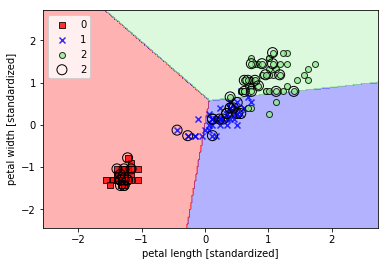

In [6]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

In [7]:
# By modify AdalineGD()
# Only work for binary classfication tasks.
class LogisticRegressionGD(object):
    """ Logistic Regression classifier using gradient decent.
    
    Parameters
    ------------
    eta: float
        Learning rate (0.0 ~ 1.0).
         
    n_iter: int
        Number of Iterations.
        
    random_state: int
        Random number generator seed for random weight initialization.
        
    Attributes
    ------------
    w_: 1D-array
        Weights after fitting.
    
    cost_: list
        Sum of squares cost each epoch.
    """
    
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.
        
        Parameters
        ------------
        X: array-like, shape = [n_samples, n_features]
            Training vectors
        
        y: array-like, shape = [n_samples]
            Real target labels.
            
        Returns
        ------------
        self: object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) - 
                    (1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
        
    def net_input(self, X):
        """ Calculate net input"""
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1.0 /(1 + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """Predict class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, -1)

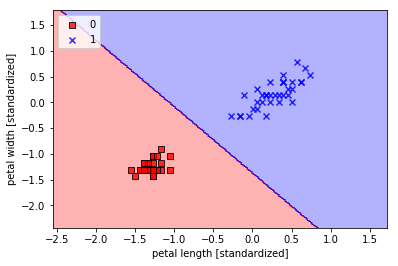

In [8]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

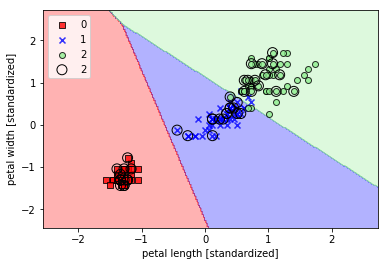

In [9]:
# Sklearn.linear_model.LogisticRegression
# Supports Multi-class settings
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=lr, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

In [10]:
print('Accuracy: %.2f' % lr.score(X_test_std, y_test))
print(iris.target_names[lr.predict(X_test_std[:3,:])])
lr.predict_proba(X_test_std[:3,:])

Accuracy: 0.98
['virginica' 'setosa' 'setosa']


array([[  3.20136878e-08,   1.46953648e-01,   8.53046320e-01],
       [  8.34428069e-01,   1.65571931e-01,   4.57896429e-12],
       [  8.49182775e-01,   1.50817225e-01,   4.65678779e-13]])

In [11]:
lr.predict(X_test_std[0, :].reshape(1, -1))
# same as: lr.predict([X_test_std[0, :]])

array([2])

# SVM

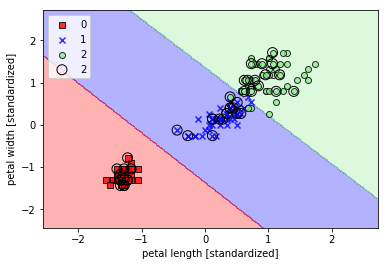

In [16]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

In [17]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


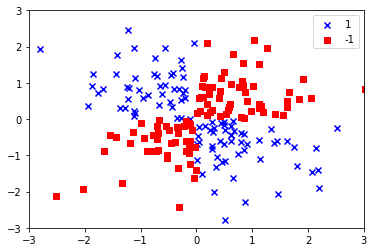

In [28]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r', marker='s',
            label='-1')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(loc='best')
plt.show()

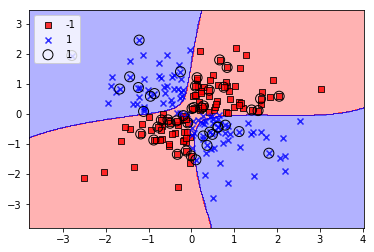

In [34]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X=X_xor,
                      y=y_xor,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.legend(loc='upper left')
plt.show()

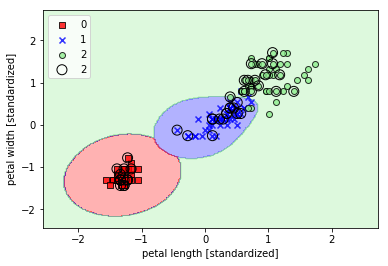

In [35]:
svm = SVC(kernel='rbf', random_state=1, gamma=2, C=10.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

# Dicision Tree

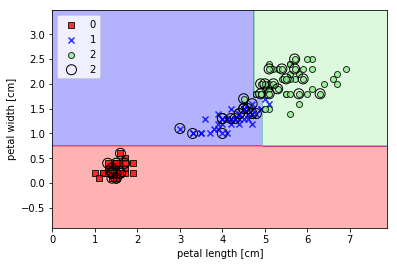

In [38]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini',
                              max_depth=4,
                              random_state=1)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined,
                      y=y_combined,
                      classifier=tree, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

In [43]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

ImportError: No module named 'pydotplus'

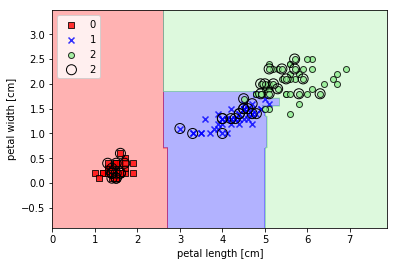

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                n_jobs=2,
                                random_state=1)
forest.fit(X_train, y_train)
plot_decision_regions(X=X_combined,
                      y=y_combined,
                      classifier=forest, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

# KNN

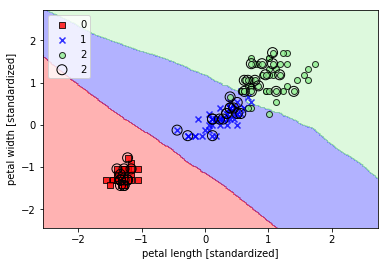

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=25,
                           metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=knn, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()